# Circuit runner program

## `run_circuits` convenience method

Evaluating quantum circuits is the fundamental operation on quantum computing systems.  The `circuit-runner` program facilitates compiling, executing, and (possibly) post-processing circuit entirely in the Cloud.  The easiest way to use the `circuit-runner` is via the convenience method accessible through a provider with `runtime` access:

In [1]:
from qiskit import IBMQ, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import hellinger_fidelity
from qiskit.ignis.mitigation.expval import expectation_value

In [2]:
IBMQ.load_account();

In [3]:
# Replace by your provider
provider = IBMQ.get_provider(project='qiskit-runtime')

In [4]:
provider.has_service('runtime')

True

The runner is accessbile via the `run_circuits` method of the provider, and supports the same functionality as transpiling and executing a circuit in Qiskit does, as well as a few additional arguments:

In [5]:
print(provider.run_circuits.__doc__)

Execute the input circuit(s) on a backend using the runtime service.

        Note:
            This method uses the IBM Quantum runtime service which is not
            available to all accounts.

        Args:
            circuits: Circuit(s) to execute.

            backend: Backend to execute circuits on.
                Transpiler options are automatically grabbed from backend configuration
                and properties unless otherwise specified.

            initial_layout: Initial position of virtual qubits on physical qubits.

            layout_method: Name of layout selection pass ('trivial', 'dense',
                'noise_adaptive', 'sabre').
                Sometimes a perfect layout can be available in which case the layout_method
                may not run.

            routing_method: Name of routing pass ('basic', 'lookahead', 'stochastic', 'sabre')

            translation_method: Name of translation pass ('unroller', 'translator', 'synthesis')

            seed_tr

of the possible arguments, `measurement_error_mitigation` is one that is unique to the Qiskit runtime, and will be used below.

We now construct an example circuit to execute via the circuit runner:

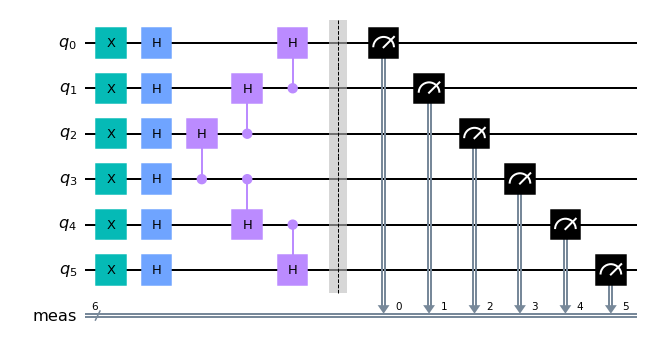

In [6]:
N = 6
qc = QuantumCircuit(N)

qc.x(range(0, N))
qc.h(range(0, N))

for kk in range(N//2,0,-1):
    qc.ch(kk, kk-1)
for kk in range(N//2, N-1):
    qc.ch(kk, kk+1)
qc.measure_all()
qc.draw('mpl',fold=-1)

In [7]:
exact_dist = {'000000': 0.015624999999999986,
              '000001': 0.015624999999999986,
              '000011': 0.031249999999999965,
              '000111': 0.06249999999999992,
              '100000': 0.015624999999999986,
              '100001': 0.015624999999999986,
              '100011': 0.031249999999999965,
              '100111': 0.06249999999999992,
              '110000': 0.031249999999999965,
              '110001': 0.031249999999999965,
              '110011': 0.06249999999999992,
              '110111': 0.12499999999999982,
              '111111': 0.4999999999999991}

Having defined our circuit(s) we can now compile and execute them on a given backend via the `run_circuits` method:

In [8]:
backend = provider.backend.ibmq_montreal

In [9]:
job = provider.run_circuits(qc, backend, shots=2048)

In [10]:
res = job.result()

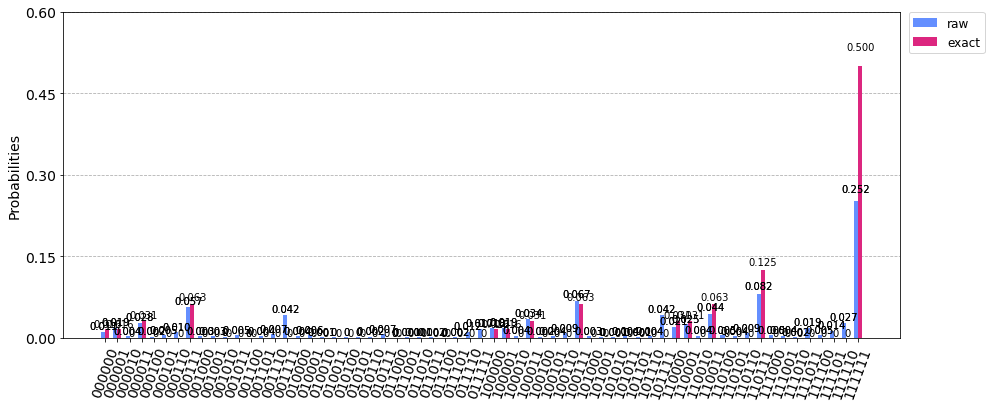

In [27]:
plot_histogram([res.get_counts(), exact_dist], legend=['raw', 'exact'], figsize=(15,6))

The overall fidelity between the ideal and raw distributions is:

In [12]:
hellinger_fidelity(res.get_counts(), exact_dist)

0.6613664634665153

## The circuit-runner program

The `run_circuits` method executes a `circuit-runner` for you internally.  It is also possible to directly call this program via the `program_id`.  Doing so also requires the custom circuit runner results class, `RunnerResult`, from the IBM Quantum package:

In [13]:
from qiskit.providers.ibmq import RunnerResult

# Specify the program inputs here.
program_inputs = {
    'circuits': qc,
    'shots': 2048,
    'optimization_level': 0,
    'measurement_error_mitigation': False
}
# Specify the backend.
options = {'backend_name': backend.name()}

# Send circuits to Cloud for execution by the circuit-runner program.
job2 = provider.runtime.run(program_id="circuit-runner",
                            options=options,
                            inputs=program_inputs,
                            result_decoder=RunnerResult
                           )

In [14]:
res2 = job2.result()

In [15]:
hellinger_fidelity(res2.get_counts(), exact_dist)

0.6656800886679829

## Measurement error mitigation in the Cloud

One of the unique options for the Qiskit runtime circuit-runner is the ability to correct for measurement errors automatically in the Cloud.  To enable this just set `measurement_error_mitigation=True` in the `run_circuits` method or `measurement_error_mitigation: True` in the `program_inputs` for the `circuit-runner` program.

In [16]:
job3 = provider.run_circuits(qc, backend, shots=2048, measurement_error_mitigation=True)

In [17]:
res3 = job3.result()

The mitigated results are returned as quasiprobabilities; a distribution that may contain negative values but never the less sums to one.  These can be accessed similar to counts using the `get_quasiprobabilities` method:

In [18]:
quasi = res3.get_quasiprobabilities()
quasi

{'000000': 0.017610766877666786,
 '000001': 0.013544237413219942,
 '000010': 0.0016114491254044416,
 '000011': 0.04490334724088187,
 '000100': 0.0005347107390901559,
 '000101': 0.00231413951641366,
 '000110': 0.0058987861608193,
 '000111': 0.0460213033794656,
 '001000': -0.00015622644792186112,
 '001001': 0.0018621141866670568,
 '001010': 0.002936545571827084,
 '001011': 0.0008279580615281473,
 '001100': 0.0008441125196188133,
 '001101': -0.00021664724073431263,
 '001110': 0.0014139761432165577,
 '001111': 0.018860086240026663,
 '010000': 0.00483300185159439,
 '010001': 0.003124645557710858,
 '010010': 0.0006982693903709498,
 '010011': 0.005207886432190985,
 '010101': -0.00032090664754734564,
 '010110': 0.002055540496923007,
 '010111': 0.012775014276896323,
 '011000': 0.0010455319000537474,
 '011001': 1.3620708047489929e-05,
 '011010': 0.00036828627836107784,
 '011011': -0.0003539314598197215,
 '011100': 0.0007405366232206002,
 '011101': 0.0007475087909013853,
 '011110': 0.002575838076

Quasiprobabilities can be directly used to compute things like expectation values:

In [19]:
print("Raw expectation value:", expectation_value(res3.get_counts())[0])
print("Mitigated expectation value:", expectation_value(quasi)[0])
print("Exact expectation value:", expectation_value(exact_dist)[0])

Raw expectation value: 0.107421875
Mitigated expectation value: 0.1484337881110358
Exact expectation value: 0.4374999999999999


It is also possible to compute the closest true probability distribution (in terms of Euclidean norm):

In [20]:
nearest_probs = quasi.nearest_probability_distribution()

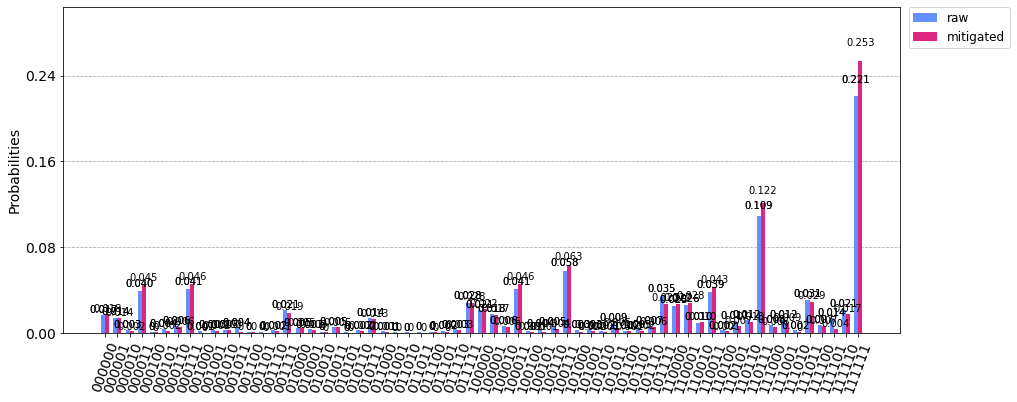

In [26]:
plot_histogram([res3.get_counts(),nearest_probs], legend=['raw', 'mitigated'], figsize=(15,6))

### Additional information on measurement mitigation

From the results object, it is also possible to determine the execution time of the mitigation process (not including calibration time), on the per experiment level:

In [23]:
res3.results[0].header.measurement_mitigation_time

0.009818805381655693

It is also possible to view the final measurment mapping that shows which physical qubit measurements correspond to classical bit values:

In [24]:
res3.results[0].header.final_measurement_mapping

{'1': 0, '2': 1, '3': 2, '7': 3, '4': 4, '0': 5}